<a href="https://colab.research.google.com/github/MRsources/Article_MAGMA24_RMRI/blob/main/scripts/TSE_PyPulseq_mr0_mrpro_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TSE sequence definition
The sequence implementation here follows the [TSE from the MR0 playground](https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_TSE_2D_multi_shot_seq.ipynb).


Current setting single shot, as reshaping of shots not yet implemented for BART



In [4]:
#@title Download and install dependencies
!pip show pypulseq &> /dev/null || pip install git+https://github.com/imr-framework/pypulseq.git &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/mzaiss/MRTwin_pulseq/raw/mr0-core/data/low_field_phantom.mat &> /dev/null

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/brainweb/__init__.py:12: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/brainweb/brainweb_data.json' mode='r' encoding='UTF-8'>
  brainweb_data = json.load(open(brainweb_data_path))


echo time set to minTE [ms] 9.600000000000001
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 130 / 130 - done


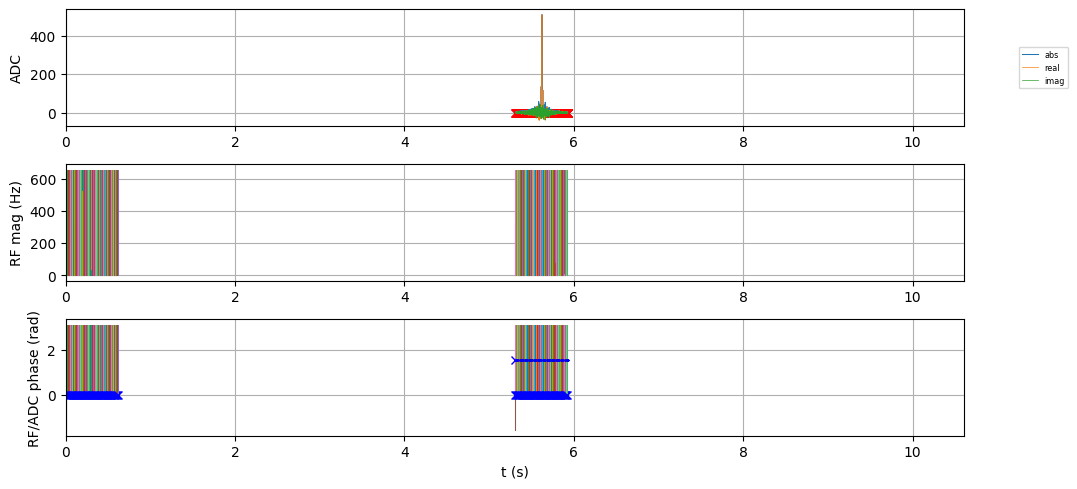

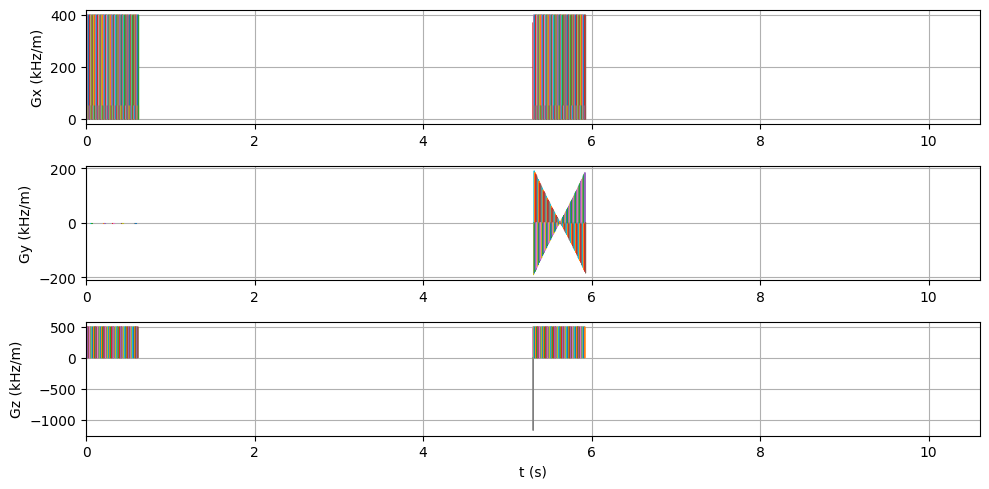

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


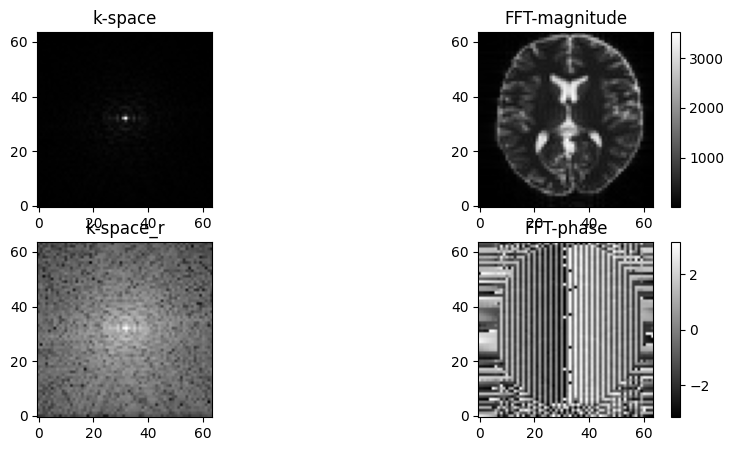

In [5]:
#@title TSE
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'TSE_2D'

# %% S1. SETUP sys
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq = pp.Sequence(system)
# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3


base_resolution= 64 # @param {type: "slider", min: 2, max: 112,step:2}

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples

TE_ms=5 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TR=5    # @param {type: "slider", min: 0.0, max: 20}
TI_s=0 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=30 # @param {type: "slider", min: 10, max: 270}
Refocusing_FA=60 # @param {type: "slider", min: 10, max: 270}
PEtype = 'linear' # @param ['centric', 'linear']
r_spoil =2 # @param {type: "slider", min: 0, max: 3}
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}
shots=1     # @param {type: "slider", min: 1, max: 8}
dumshots=1  # @param {type: "slider", min: 0, max: 3}
dumref=0    # @param {type: "slider", min: 0, max: 10}


# Define rf events
rf1, gz1, gzr1 = pp.make_sinc_pulse(
    flip_angle=Excitation_FA * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

rf2, gz2, _ = pp.make_sinc_pulse(
    flip_angle=Refocusing_FA* np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True)

dwell=50e-6*2

G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=0*gx.rise_time, system=system)
gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


if PE_grad_on:
    if PEtype == 'centric':
      phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov
    else:
      phenc = np.arange(-Nphase // 2, Nphase // 2) / fov
else:
    phenc = np.zeros((Nphase, ))

# the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2
minTE2=round(minTE2/10e-5)*10e-5

# to realize longer TE,  we introduce a TEdelay that is added before and after the encoding period
TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

if TEd==0:
  print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
else:
  print(' TE [ms]', 2*(minTE2 +TEd)*1000)

TRd=0
if dumshots+shots>1:
  TRd=TR - Nphase//shots*TE

# seq loop starts
for shot in range(-dumshots, shots):
  # FLAIR
  if TI_s>0:
    seq.add_block(rf_prep)
    seq.add_block(pp.make_delay(TI_s))
    seq.add_block(gx_pre0)

  seq.add_block(rf1,gz1)
  seq.add_block(gx_pre0,gzr1)

  # last timing step is to add TE/2 also between excitation and first ref pulse
  # from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
  seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

  if shot<0:
    phenc_dum=np.zeros(Nphase//shots+dumref) # add refocusing dummies
  else:
    phenc_dum=np.concatenate([np.repeat(np.nan, dumref), phenc[shot::shots]]) # add refocusing dummies

  for ii, encoding in enumerate(phenc_dum):  # e.g. -64:63
    dum_ref_flag=0
    if np.isnan(encoding): encoding = 1e-8; dum_ref_flag=1 # no pe gradient if refdummy

    gp  = pp.make_trapezoid(channel='y', area=+encoding , duration=1e-3, system=system)
    gp_ = pp.make_trapezoid(channel='y', area=-encoding, duration=1e-3, system=system)

    seq.add_block(rf2,gz2)
    seq.add_block(pp.make_delay(TEd)) # TE delay
    seq.add_block(gx_prewinder, gp)

    if shot<0 or dum_ref_flag: #added dummy shots
      seq.add_block(gx)
    else:
      seq.add_block(adc, gx)
    seq.add_block(gx_prewinder, gp_)
    seq.add_block(pp.make_delay(TEd)) # TE delay
  seq.add_block(pp.make_delay(TRd))

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()
seq.write('external.seq')
seq0 = mr0.Sequence.import_file('external.seq')

reco = mr0.reco_adjoint(signal, seq0.get_kspace(), (Nread, Nphase, 1), (0.2, 0.2, 1))

kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()

# %% S4: MR IMAGE RECON of signal ::: #####################################
plt.figure()
plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()),cmap='gray')
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())),cmap='gray')
plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(reco.numpy()),cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(reco.numpy()), vmin=-np.pi, vmax=np.pi,cmap='gray')
plt.colorbar()

In [6]:
#@title simple recon
def kspace_sort(kdat,permvec):
    kspace=kdat.squeeze(4).squeeze(3)  #read phase1 phase2 (channels maps) echos ...
    ipermvec = np.argsort(permvec)
    kspace=kspace[:,ipermvec,:,:]
    return kspace

def recon(kspace):
    x = torch.fft.ifftshift(kspace,dim=(0,1,2))
    x = torch.fft.fftn(x,dim=(0,1,2))
    img = torch.fft.fftshift(x,dim=(0,1,2))
    return img.numpy()


def show(img):
    vm=np.max(np.abs(img))

    for zz in range(0,img.shape[2]):
      plt.figure()
      for ii in range(0,img.shape[3]):
        plt.subplot(1,4,ii+1); plt.title(c+' slice '+str(zz+1))
        plt.imshow(np.rot90(np.abs(img[:,:,zz,ii])),cmap='gray',vmin=0,vmax=vm); plt.axis('off')
      plt.tight_layout()
      plt.show()

def show_traj(ktraj):
    # ktraj is not yet used and also probably not ready for BART
    plt.figure()
    plt.subplot(3,1,1); plt.plot(ktraj[0,:,0],ktraj[1,:,0],'x'); plt.xlabel('kx');plt.ylabel('ky')
    plt.subplot(3,1,2);plt.plot(ktraj[0,:,0],ktraj[2,:,0],'x'); plt.xlabel('kx'); plt.ylabel('kz')

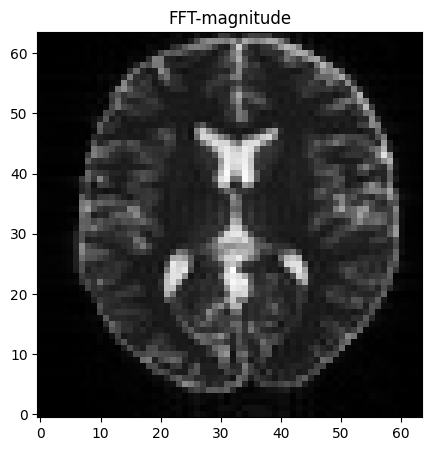

In [7]:
#read phase1 phase2 channels maps echos ...
Nc=1
Nphase3D=1
kdat = torch.reshape((signal), (Nc,Nphase3D,Nphase, Nread)).clone().permute(3,2,1,0)
# Add singleton dimensions for channels and maps
kdat_bart=kdat.unsqueeze(3).unsqueeze(4)

k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace(trajectory_delay=0)
fov3D=np.array([fov, fov, slice_thickness])
ktraj = k_traj_adc  * fov3D[:,None]
ktraj = ktraj.reshape(3, Nc,-1).transpose([0,2,1])

#recon
img_simple = recon(kdat_bart)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(img_simple.squeeze()),cmap='gray')

# MRpro recon

In [14]:
!pip install mrpro &> /dev/null
# Imports
import matplotlib.pyplot as plt
from mrpro.algorithms.reconstruction import DirectReconstruction
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryPulseq

# Assume `seq_file_path` and `k_space_data` are provided:
# seq_file_path: Path to the Pulseq sequence file
# k_space_data: List of complex k-space data for a single coil

# Create a KTrajectoryPulseq instance using the provided sequence file
k_traj = KTrajectoryPulseq(seq_path='external.seq')

signal_mrpro = torch.reshape(signal, (1, 1, Nphase, Nread)).permute(3, 2, 1, 0)  # (Nread, Nphase, Nphase3D=1, Nc=1)

# Wrap the k-space data in the KData structure with the calculated trajectory
kdata = KData(signal_mrpro, k_traj)
kdata.header.recon_matrix=(Nread, Nphase)
kdata.header.encoding_matrix=(Nread, Nphase)

# Perform direct reconstruction
direct_reconstruction = DirectReconstruction(kdata)
reconstructed_image = direct_reconstruction(kdata)

# Plot the reconstructed image
plt.imshow(reconstructed_image.rss()[0, 0, :, :], cmap='gray')
plt.title('Reconstructed Image Using Pulseq Trajectory')
plt.axis('off')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'property' object has no attribute 'type_along_kzyx'

# BART reconstruction

In [6]:
%%bash
# install BART
apt-get install -y bart > /dev/null
wget https://raw.githubusercontent.com/mrirecon/bart/master/python/cfl.py &> /dev/null

In [7]:
# sort kspace
# kspace = kspace_sort(kdat,permvec)
kspace = kdat

# export unsorted kspace and trajectory to files
import cfl as cfl
cfl.writecfl('ksp', kspace.numpy())

In [8]:
%%bash
# Cartesian recon (use forward FFT to avoid flip)
bart fft $(bart bitmask 0 1 2) ksp img

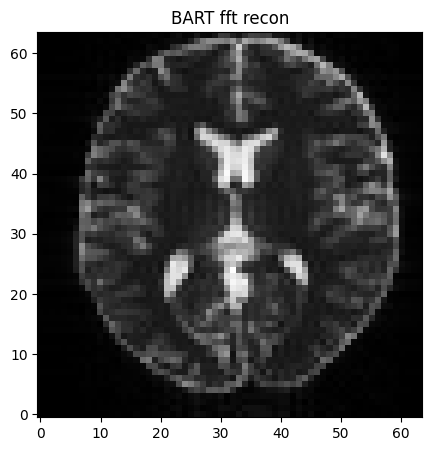

In [9]:
plt.title('BART fft recon')
mr0.util.imshow(np.abs(cfl.readcfl('img')),cmap='gray')

In [10]:
# export unsorted kspace and trajectory to files
import cfl as cfl
import os
cfl.writecfl('kdat', kdat.numpy())
cfl.writecfl('ktraj', ktraj)

os.environ["Ntot"] = str(Nread*Nphase)

In [11]:
%%bash
# reshape to BART convention#
Nread=64
Nphase=64

bart reshape $(bart bitmask 0 1 2) 1 $((Nread * Nphase )) 1 kdat kdatR
bart transpose 2 5 ktraj ktrajR
# adjoint nufft
bart nufft -a ktrajR kdatR imgF
# flip image correctly
bart flip $(bart bitmask 0 1 2) imgF img

Est. image size: 256 64 6
Done.


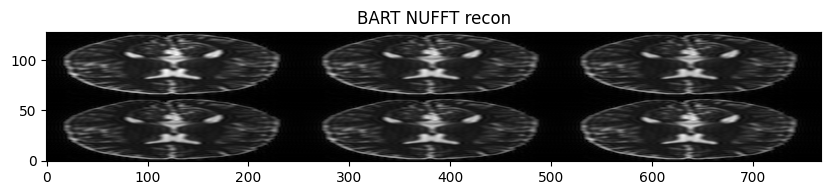

In [12]:
plt.title('BART NUFFT recon')
mr0.util.imshow(np.abs(cfl.readcfl('imgF')),cmap='gray')

In [13]:
show(cfl.readcfl('img').squeeze())

IndexError: tuple index out of range

<Figure size 1000x500 with 0 Axes>

In [ ]:
%%bash
bart ones 3 64 64 6 sens
bart transpose 3 5 ksp kspR
bart pics -r0.01 kspR sens img

In [ ]:
show(cfl.readcfl('img').squeeze())